In [2]:
import pickle
import os
import matplotlib.pyplot as plt
import numpy as np

In [6]:
def load_series(algorithm: str, upper_bound: str, task_name: str, root_dir: str):
    """
    kv_data has the following keys: 
    - 'S'
    - 'f(S)'
    - 'c(S)'
    - 'Lambda'
    - 'AF'
    """

    res = []
    for name in os.listdir(root_dir):
        algo, up, task, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound and task == task_name:
            # print(name)
            file_path = os.path.join(root_dir, name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['f(S)'], kv_data['Lambda'], kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    #print(res)
    X, Y, Z, W = list(zip(*res))   # change it to two columns
    return X, Y, Z, W


Diagramming 

+ Each row has 2 columns.
+ Each row denotes a different task.
+ Y axis of 1st column denotes f(S) and Y axis of 2nd column denotes AF.
+ In each subfigure, X axis is budget. Different color denotes different (algorithm, upper-bound) combination.

Analysis Result
+ UB3 <= UB1
+ greedy max has better approximation ratio than mgreedy

[(1.0, 0.0, inf, 0.0), (2.0, 0.0002, 0.0004105263157894737, 0.48717948717948717), (3.0, 0.0002, 0.0005157894736842106, 0.3877551020408163), (4.0, 0.0004, 0.0006210526315789474, 0.6440677966101694), (5.0, 0.0004, 0.0007263157894736842, 0.5507246376811594), (6.0, 0.0006, 0.0008315789473684212, 0.721518987341772), (7.0, 0.0006, 0.000936842105263158, 0.6404494382022471), (8.0, 0.0008, 0.0010421052631578948, 0.7676767676767677), (9.0, 0.0008, 0.0011473684210526317, 0.6972477064220183)]
[(1.0, 0.0, inf, 0.0), (2.0, 0.0002, 0.0004, 0.5), (3.0, 0.0002, 0.0004, 0.5), (4.0, 0.0004, 0.0006, 0.6666666666666667), (5.0, 0.0004, 0.0006, 0.6666666666666667), (6.0, 0.0006, 0.0007999999999999999, 0.75), (7.0, 0.0006, 0.0007999999999999999, 0.75), (8.0, 0.0008, 0.0009999999999999998, 0.8000000000000002)]
[(1.0, 0.0, inf, 0.0), (2.0, 0.0002, inf, 0.0), (3.0, 0.0002, inf, 0.0), (4.0, 0.0004, 0.0008210526315789472, 0.4871794871794873), (5.0, 0.0004, 0.000926315789473684, 0.43181818181818193), (6.0, 0.0006, 

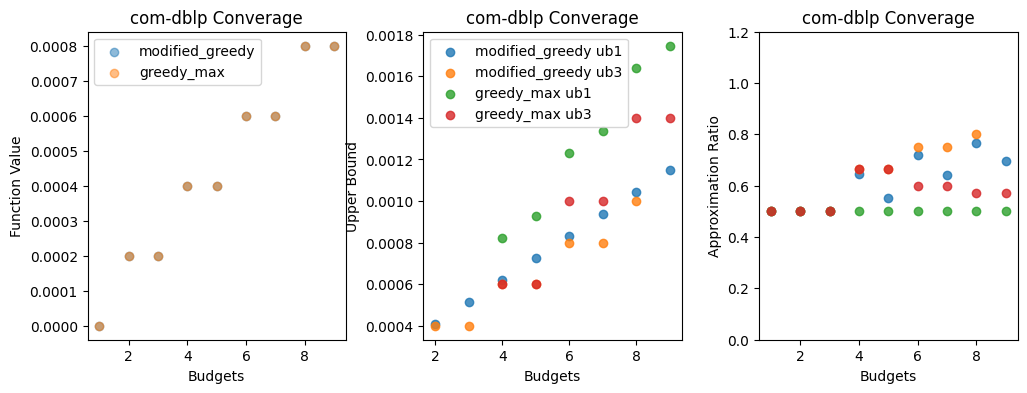

In [18]:
upper_bounds = ["ub1", "ub3"]
algos = ["modified_greedy"]
task_names = ["DblpGraphCoverage"]
# task_names = ["FacebookGraphCoverage"]
# task_names = ["MovieRecommendation"]
# task_names = ["RevenueMax", "IdealMaxCovModel", "MovieRecommendation", "ImageSummarization"]


task2title = {
    #"RevenueMax": "Revenue Maximization", 
    #"IdealMaxCovModel": "Maximum Coverage", 
    #"MovieRecommendation": "Movie Recommendation", 
    #"ImageSummarization": "Image Summarization",
    "DblpGraphCoverage":"com-dblp Converage",
    #"FacebookGraphCoverage":"ego-facebook Converage"
}
result_root_dir = "../result"


rows = len(task_names)
cols = 3
height, width = 4,4
fig, axes = plt.subplots(rows, cols, figsize=(cols * width, rows * height),
    gridspec_kw={
	'wspace' : 0.3,
	'hspace' : 0.3,
})

if rows == 1:
    left_ax, middle_ax, right_ax = axes
    task_name = task_names[0]

    left_ax.set_xlabel("Budgets")
    left_ax.set_ylabel("Function Value")
    left_ax.set_title(task2title[task_name])

    middle_ax.set_xlabel("Budgets")
    middle_ax.set_ylabel("Upper Bound")
    middle_ax.set_title(task2title[task_name])
    if task_name == "RevenueMax":
        middle_ax.set_ylim(-5, 140)

    right_ax.set_xlabel("Budgets")
    right_ax.set_ylabel("Approximation Ratio")
    right_ax.set_ylim(0.0, 1.2)
    right_ax.set_title(task2title[task_name])

    for algo in algos:
        for up in upper_bounds:
            X, Y, Z, W = load_series(algo, up, task_name, result_root_dir)

            if up == "ub1":
                # function value: same algorithm should have same function value
                left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)

            middle_ax.scatter(X, Z, label="{} {}".format(algo, up), alpha=0.8)
            
            # TODO: floor and ceiling
            W = np.minimum(np.ones(shape=len(W)), np.array(W))
            W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
            right_ax.scatter(X, W, label="{} {}".format(algo, up), alpha=0.8)

    left_ax.legend()
    middle_ax.legend()
    # right_ax.legend()
else:
    for row_axes, task_name in zip(axes, task_names):
        left_ax, middle_ax, right_ax = list(row_axes)

        left_ax.set_xlabel("Budgets")
        left_ax.set_ylabel("Function Value")
        left_ax.set_title(task2title[task_name])

        middle_ax.set_xlabel("Budgets")
        middle_ax.set_ylabel("Upper Bound")
        middle_ax.set_title(task2title[task_name])
        if task_name == "RevenueMax":
            middle_ax.set_ylim(-5, 140)

        right_ax.set_xlabel("Budgets")
        right_ax.set_ylabel("Approximation Ratio")
        right_ax.set_ylim(0.0, 1.2)
        right_ax.set_title(task2title[task_name])

        for algo in algos:
            for up in upper_bounds:
                X, Y, Z, W = load_series(algo, up, task_name, result_root_dir)

                if up == "ub1":
                    # function value: same algorithm should have same function value
                    left_ax.scatter(X, Y, label="{}".format(algo), alpha=0.5)

                middle_ax.scatter(X, Z, label="{} {}".format(algo, up), alpha=0.8)
                
                # TODO: floor and ceiling
                W = np.minimum(np.ones(shape=len(W)), np.array(W))
                W = np.maximum(0.5 * np.ones(shape=len(W)), np.array(W))
                right_ax.scatter(X, W, label="{} {}".format(algo, up), alpha=0.8)

        left_ax.legend()
        middle_ax.legend()
        # right_ax.legend()
    
plt.show()

# Misc

Categories
+ Upper bound 1 and 2
+ MGreedy and GreedyMax

In [10]:
def load_series(algorithm, upper_bound):
    res = []
    for name in os.listdir("./result"):
        algo, up, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound:
            # print(name)
            file_path = "./result/{}".format(name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['AF']) )
    res = sorted(res, key=lambda x: x[0])
    X, Y = list(zip(*res))   # change it to two columns
    return X, Y

upper_bounds = ["ub1", "ub3"]
algos = ["modified_greedy", "greedy_max"]
X, Y = load_series("modified_greedy", "ub1")

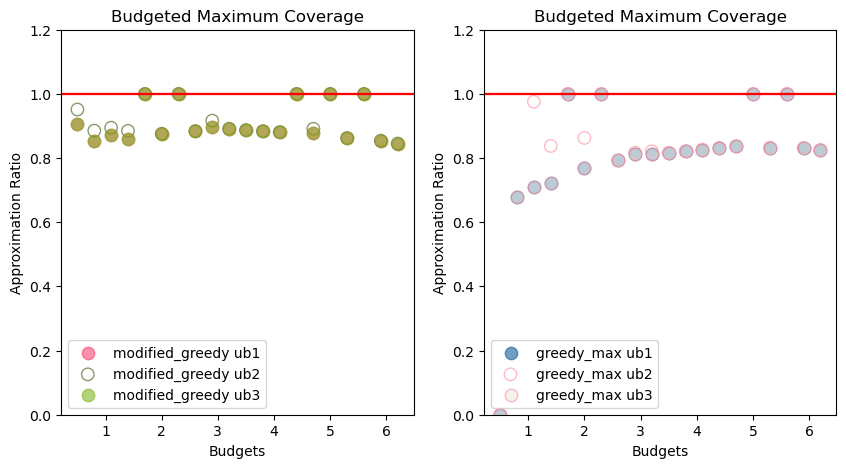

In [11]:
face_colors = [
    ['#FB4570', 'none', '#81B622'],
    ['#145DA0', 'none', '#EFEBE0'],
]

edge_colors = [
    ['#FB4570', '#3D550C', '#81B622'],
    ['#145DA0', '#FB8DA0', '#FB8DA0'],
]

fig, axes = plt.subplots(1,2, figsize=(10,5))


for r, algo in enumerate(algos):
    ax = axes[r]
    for c, up in enumerate(upper_bounds):
        X, Y = load_series(algo, up)
        ax.scatter(X, Y, s=80, facecolors=face_colors[r][c], edgecolors=edge_colors[r][c], alpha=0.6, label='{} {}'.format(algo, up))
        ax.set_xlabel("Budgets")
        ax.set_ylabel("Approximation Ratio")
        ax.set_ylim([0., 1.2])
        ax.axhline(y = 1.0, color='r', linestyle='-')
        ax.legend()
        ax.set_title("Budgeted Maximum Coverage")
plt.show()

modified_greedy ub1
(20.972159640005035, 26.929117781633003, 31.008052067135456, 34.901814470365665, 33.0, 41.10659973147058, 38.0, 46.38087476651967, 49.00607587142177, 51.603913219345564, 54.11314227622458, 56.58079056023376, 59.033054617962904, 53.0, 63.83243814980301, 57.0, 68.42050923132604, 60.0, 72.57880839111485, 74.5375455750449)
modified_greedy ub2
(19.972159640005035, 25.982605175346855, 30.179676980820453, 33.901814470365665, 33.0, 41.10659973147058, 38.0, 46.38087476651967, 48.00607587142177, 51.603913219345564, 54.11314227622458, 56.58079056023376, 59.033054617962904, 53.0, 62.83243814980301, 57.0, 68.42050923132604, 60.0, 72.57880839111485, 74.5375455750449)
modified_greedy ub3
(20.972159640005035, 26.929117781633003, 31.008052067135456, 34.901814470365665, 33.0, 41.10659973147058, 38.0, 46.38087476651967, 49.00607587142177, 51.603913219345564, 54.11314227622458, 56.58079056023376, 59.033054617962904, 53.0, 63.83243814980301, 57.0, 68.42050923132604, 60.0, 72.57880839111

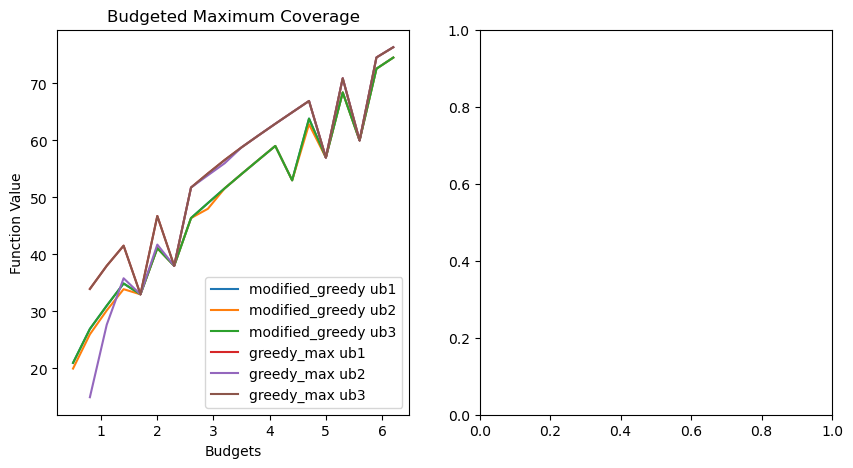

In [14]:
def load_series(algorithm, upper_bound):
    res = []
    for name in os.listdir("./result"):
        algo, up, b = name.strip()[:-5].split('-')
        if algo == algorithm and up == upper_bound:
            # print(name)
            file_path = "./result/{}".format(name)
            with open(file_path, "rb") as rd:
                kv_data = pickle.load(rd)
            res.append( (eval(b), kv_data['Lambda']) )
    res = sorted(res, key=lambda x: x[0])
    X, Y = list(zip(*res))   # change it to two columns
    return X, Y

fig, axes = plt.subplots(1,2, figsize=(10,5))

for r, algo in enumerate(algos):
    ax = axes[0]
    for c, up in enumerate(upper_bounds):
        X, Y = load_series(algo, up)
        print(algo, up)
        print(Y)
        ax.plot(X, Y, label="{} {}".format(algo, up))
        ax.set_xlabel("Budgets")
        ax.set_ylabel("Function Value")
        ax.legend()
        ax.set_title("Budgeted Maximum Coverage")
plt.show()